# Training temperature prediction model

**Author: Miguel Ángel Ballester Granell**

Code inspired by Tensorflow tutorial https://www.tensorflow.org/tutorials/structured_data/time_series

This notebook contains the necessary code for training and evaluating the recurrent neural network for temperature forecast.

## Libraries

In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import files

## Data loading

In [2]:
# Load data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

# Split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train = df[0:int(n*0.7)]
val = df[int(n*0.7):int(n*0.9)]
test = df[int(n*0.9):]

## Preprocessing pipeline

In [3]:
class WeatherPreprocessing():

  def __init__(self):
    self.data = None
    self.means = None
    self.stds = None

  def clean(self):

    # slice [start:stop:step], starting from index 5 take every 6th record, to take one sample per hour
    self.data = self.data.copy().loc[5::6]

    self.date_time = pd.to_datetime(self.data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

    # Remove incorrect data ---------------
    wv = self.data['wv (m/s)']
    bad_wv = wv == -9999.0
    wv[bad_wv] = 0.0

    max_wv = self.data['max. wv (m/s)']
    bad_max_wv = max_wv == -9999.0
    max_wv[bad_max_wv] = 0.0

    
  def feat_eng(self):
    # Create direction vector combining direction degree and speed -------------------
    wv = self.data.pop('wv (m/s)')
    max_wv = self.data.pop('max. wv (m/s)')

    # Convert to radians.
    wd_rad = self.data.pop('wd (deg)')*np.pi / 180

    # Calculate the wind x and y components.
    self.data['Wx'] = wv*np.cos(wd_rad)
    self.data['Wy'] = wv*np.sin(wd_rad)

    # Calculate the max wind x and y components.
    self.data['max Wx'] = max_wv*np.cos(wd_rad)
    self.data['max Wy'] = max_wv*np.sin(wd_rad)

    # Set "hour of day " and "hour of year" features using sin and cos ------------------
    timestamp_s = self.date_time.map(datetime.datetime.timestamp)

    day = 24*60*60
    year = (365.2425)*day

    self.data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    self.data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    self.data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    self.data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


  def normalize(self, calculate_metrics):
    if calculate_metrics:
      self.means = self.data.mean()
      self.stds = self.data.std()
    else:
      self.means = self.means[self.data.columns]
      self.stds = self.stds[self.data.columns]

    self.data = (self.data - self.means) / self.stds

    
  def fit(self, data):
    self.data = data
    # Clean data
    self.clean()
    # Feature engineering
    self.feat_eng()
    # Normalization
    self.normalize(calculate_metrics=True)

  def fit_transform(self, data):
    self.data = data
    # Clean data
    self.clean()
    # Feature engineering
    self.feat_eng()
    # Normalization
    self.normalize(calculate_metrics=True)

    return self.data

  def transform(self, data):
    self.data = data
    # Clean data
    self.clean()
    # Feature engineering
    self.feat_eng()
    # Normalization
    self.normalize(calculate_metrics=False)

    return self.data

  def save_params(self, path):
    # Create dataframe with means and standard deviations from training
    params = pd.DataFrame({'feature': self.means.index, 'mean': self.means.values, 'std': self.stds.values})
    # Save as CSV
    params.to_csv(path, index=False)
    if 'google.colab' in str(get_ipython()):
      files.download(path)

  def load_params(self, path):
    params = pd.read_csv(path)

    means = params['mean']
    means.index = params['feature']
    self.means = params['mean']

    stds = params['std']
    stds.index = params['feature']
    self.stds = params['std']


In [4]:
preprocess_pl = WeatherPreprocessing()

train_df = preprocess_pl.fit_transform(data=train)

val_df = preprocess_pl.transform(data=val)

test_df = preprocess_pl.transform(data=test)

num_features = train_df.shape[1]

preprocess_pl.save_params('preprocess_params.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945312,-1.982498,-2.041914,-1.918985,1.117072,-1.302871,-1.477334,-0.790414,-1.480047,-1.482708,2.218550,0.193410,0.221176,0.111140,0.217940,0.366097,1.366039,-0.061035,1.428453
11,0.959775,-2.078398,-2.138193,-2.060975,1.044588,-1.330162,-1.534364,-0.786262,-1.536200,-1.539045,2.325735,0.172987,0.222115,0.109458,0.227811,0.707187,1.224765,-0.060012,1.428442
17,0.986289,-2.070310,-2.132462,-2.045198,1.062709,-1.328863,-1.527235,-0.788338,-1.528713,-1.532003,2.324026,0.207983,0.276281,0.111217,0.324092,1.000088,1.000031,-0.058989,1.428431
23,1.004367,-2.098040,-2.161116,-2.096831,1.008346,-1.336660,-1.546245,-0.782111,-1.547431,-1.553129,2.358940,0.270344,0.195281,0.246908,0.145188,1.224839,0.707151,-0.057966,1.428419
29,1.061012,-2.165054,-2.232179,-2.187188,0.984185,-1.353555,-1.579513,-0.782111,-1.581122,-1.585992,2.446348,0.112264,0.350833,0.048639,0.402067,1.366124,0.366086,-0.056943,1.428407


## Window generator

In [6]:
class WindowGenerator():

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model.model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, :],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

      plt.xlabel('Time [h]')

  def make_dataset(self, data, shuffle):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df, shuffle=True)

  @property
  def val(self):
    return self.make_dataset(self.val_df, shuffle=False)

  @property
  def test(self):
    return self.make_dataset(self.test_df, shuffle=False)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): ['T (degC)']

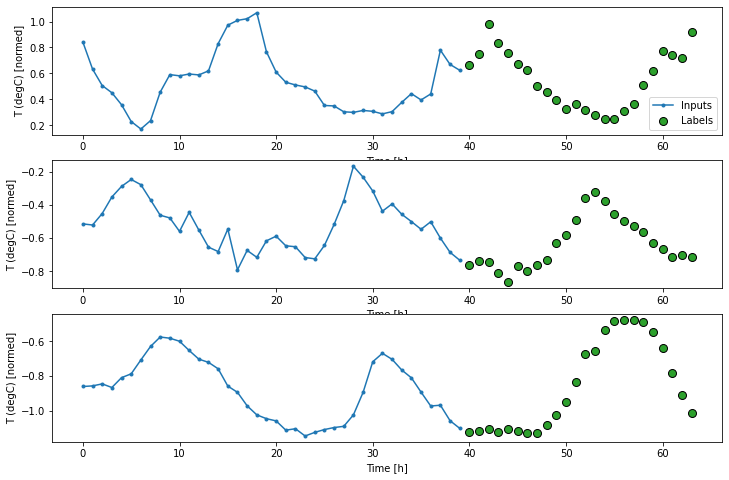

In [7]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=40,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['T (degC)']
)

multi_window.plot()
multi_window

## Define model

In [8]:
class WeatherModel():

  def __init__(self, input_shape):
    # Initialize model
    # Input layer (batch, timesteps, features)
    inputs = tf.keras.layers.Input(shape=input_shape)
    # LSTM layer, 12 units
    lstm = tf.keras.layers.LSTM(12)(inputs)
    # Dense layer
    dense = tf.keras.layers.Dense(
        OUT_STEPS*1,
        activation='linear',
        kernel_initializer=tf.initializers.zeros
    )(lstm)
    # Shape => [batch, out_steps, label_features]
    reshape = tf.keras.layers.Reshape([OUT_STEPS, 1])(dense)

    multi_lstm_model = tf.keras.Model(inputs=inputs, outputs=reshape)

    self.model = multi_lstm_model


  def summary(self):
    return self.model.summary()
  
  def compile_and_fit(self, window, patience, max_epochs):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    self.model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    self.history = self.model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])

  def predict(self, window):
    return self.model.predict(window)

  def save_weights(self, **kwargs):
    self.model.save_weights(**kwargs)
    if 'google.colab' in str(get_ipython()):
      files.download(kwargs['filepath'])

  def load_weights(self, **kwargs):
    self.model.load_weights(**kwargs)

  def visualize_loss(self):
    loss = self.history.history["loss"]
    val_loss = self.history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title('Loss evolution during training')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    


In [9]:
model = WeatherModel(input_shape=(multi_window.input_width, len(multi_window.column_indices)))

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 19)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 12)                1536      
_________________________________________________________________
dense (Dense)                (None, 24)                312       
_________________________________________________________________
reshape (Reshape)            (None, 24, 1)             0         
Total params: 1,848
Trainable params: 1,848
Non-trainable params: 0
_________________________________________________________________


## Training

In [10]:
model.compile_and_fit(multi_window, patience=4, max_epochs=30)

Epoch 1/30
1532/1532 [==============================] - 27s 17ms/step - loss: 0.3139 - mean_absolute_error: 0.4077 - val_loss: 0.0883 - val_mean_absolute_error: 0.2281
Epoch 2/30
1532/1532 [==============================] - 25s 16ms/step - loss: 0.0824 - mean_absolute_error: 0.2202 - val_loss: 0.0820 - val_mean_absolute_error: 0.2185
Epoch 3/30
1532/1532 [==============================] - 25s 16ms/step - loss: 0.0766 - mean_absolute_error: 0.2111 - val_loss: 0.0799 - val_mean_absolute_error: 0.2148
Epoch 4/30
1532/1532 [==============================] - 25s 16ms/step - loss: 0.0739 - mean_absolute_error: 0.2065 - val_loss: 0.0778 - val_mean_absolute_error: 0.2110
Epoch 5/30
1532/1532 [==============================] - 25s 16ms/step - loss: 0.0720 - mean_absolute_error: 0.2032 - val_loss: 0.0773 - val_mean_absolute_error: 0.2101
Epoch 6/30
1532/1532 [==============================] - 25s 16ms/step - loss: 0.0705 - mean_absolute_error: 0.2007 - val_loss: 0.0766 - val_mean_absolute_error:

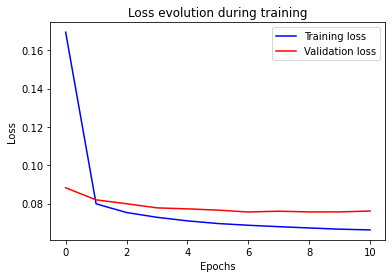

In [11]:
model.visualize_loss()

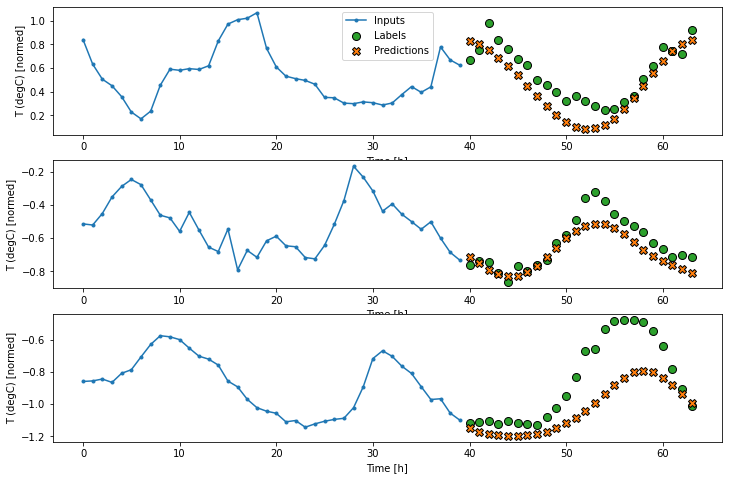

In [12]:
multi_window.plot(model)

## Error analysis

In [13]:
def visualize_model_error(true, pred, dataset):

  errors = y_true - y_pred

  print('Model results (' + dataset + ')')
  mean_sqr_error = np.mean(errors**2)

  print('Mean squared error: ' + str(round(mean_sqr_error, 4)))
  ss_res = np.sum(errors**2)
  ss_tot = np.sum((y_true - np.mean(y_true))**2)
  r2 = 1 - ss_res/ss_tot

  print('R2: ' + str(round(r2, 4)))

  fig, axs = plt.subplots(1,1, figsize=(15,5))

  sns.violinplot(data=[errors[:,i,0] for i in range(errors.shape[1])], ax=axs)

  axs.set_title('Error distribution for each predicted timestep - ' + dataset)
  axs.set_xlabel('Timestep')

  plt.show()

### Training data

Model results (Training)
Mean squared error: 1.8977
R2: -0.9016


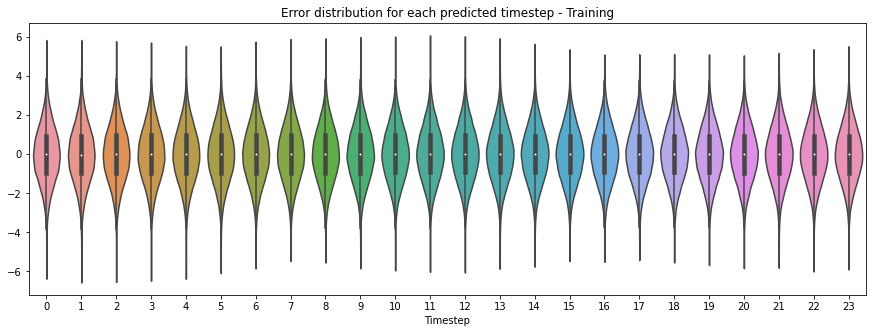

In [14]:
y_true = np.concatenate([y for x, y in multi_window.train], axis=0)
y_pred = model.predict(multi_window.train)

visualize_model_error(y_true, y_pred, 'Training')

### Validation data

Model results (Validation)
Mean squared error: 0.0761
R2: 0.9025


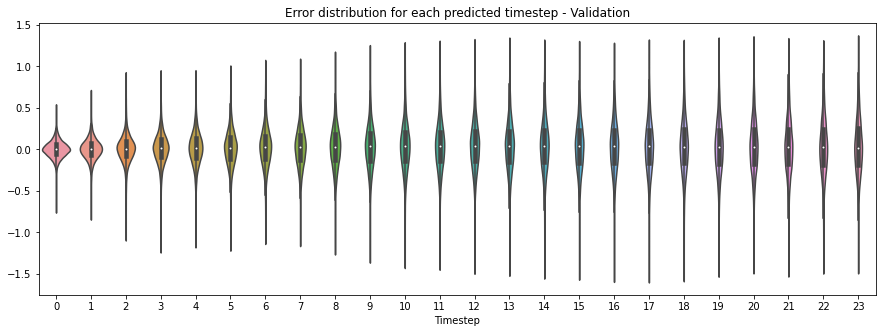

In [15]:
y_true = np.concatenate([y for x, y in multi_window.val], axis=0)
y_pred = model.predict(multi_window.val)

visualize_model_error(y_true, y_pred, 'Validation')

### Test data

Model results (Test)
Mean squared error: 0.0639
R2: 0.9215


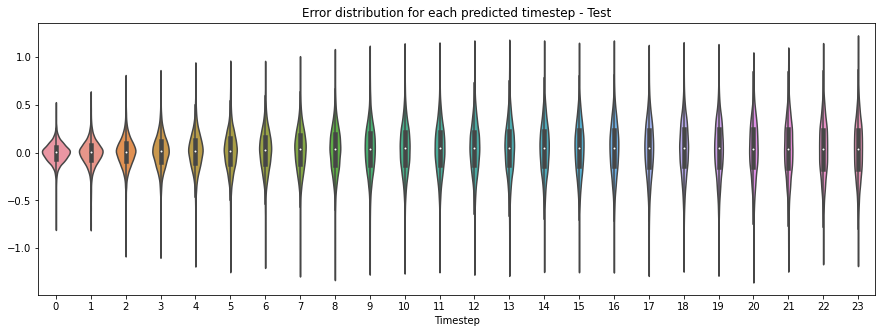

In [16]:
y_true = np.concatenate([y for x, y in multi_window.test], axis=0)
y_pred = model.predict(multi_window.test)

visualize_model_error(y_true, y_pred, 'Test')

## Save model

In [17]:
model.save_weights(filepath='weather_model.h5')

# model.load_weights(path='weather_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>